In [1]:
from model import MusicSep
from dataset import CustomDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import os
from glob import glob
import time

from torch.utils.tensorboard import SummaryWriter
log_dir = "./logs"
writer = SummaryWriter(log_dir)

2023-07-30 22:32:04.361268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 22:32:05.191429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt

def plot_loss(losses):
    plt.figure()
    iterations = len(losses)

    # Plot losses
    plt.plot(losses, label='Loss', marker='o')

    # Plot accuracy
    # plt.plot(iterations, accuracy, label='Accuracy', marker='x')

    # Add labels, title, and legend
    plt.xlabel('Test Iteration')
    plt.ylabel('Value')
    plt.title('Losses')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}, (cuda:0 is prefered over CPU).")  

Using device cuda:0, (cuda:0 is prefered over CPU).


In [4]:
import csv

def saving_loss(losses):
    filename = 'losses.csv'
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Test Iteration', 'Loss'])  # Header row
        for i, loss in enumerate(losses, start=1):
            writer.writerow([i, loss])

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_folder, gt_folder, transform=None):
        self.data_folder = data_folder
        self.gt_folder = gt_folder
        self.transform = transform

        self.data_filenames = sorted(os.listdir(data_folder))
        self.gt_filenames = sorted(os.listdir(gt_folder))
    def __len__(self):
        return len(self.data_filenames)
        #return 200

    def __getitem__(self, idx):
        # Load and preprocess the input and output data
        data_filename = self.data_filenames[idx]
        gt_filename = self.gt_filenames[idx]

        data_path = os.path.join(self.data_folder, data_filename)
        gt_path = os.path.join(self.gt_folder, gt_filename)
        
        input_tensor = torch.load(data_path)
        input_tensor = torch.stack((input_tensor[0, :, :, 0], input_tensor[0, :, :, 1], input_tensor[1, :, :, 0], input_tensor[1, :, :, 1]))
        output_tensor = torch.load(gt_path)
        output_tensor = torch.stack(((output_tensor[0, :, :, 0], output_tensor[0, :, :, 1], output_tensor[1, :, :, 0], output_tensor[1, :, :, 1])))

        return input_tensor, output_tensor

In [6]:
data_folder = '../data/data_spect_real_513/train/mix'
gt_folder = '../data/data_spect_real_513/train/vocals'

In [7]:
dataset = CustomDataset(data_folder, gt_folder, transform=None)
batch_size = 8
print(dataset.__len__())
num_workers = 1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers, multiprocessing_context="fork")

1342


In [ ]:
# Step 2: Choose a loss function
#criteria = SSIMLoss()
# criteria = criteria.to(device)
criteria = nn.L1Loss()
print("Start!")

folder_name = "./models/unet/"
file_paths = glob(folder_name + "*.pt")
number = len(file_paths)

path = folder_name + "model_vocals_"
if number < 10:
    path = path + "0" + str(number) + ".pt"
else:
    path = path + str(number) + ".pt"

print("The saving path is: ", path)
print("                      ")

# Step 3: Choose an optimizer and set learning rate
#model = UNet(n_channels=2, n_classes=1, bilinear=1)
model = MusicSep()
model = model.to(device)
#inicijalno 0.0001 posle se mnozi za 0.9 na svakih 10k koraka
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
dataset_size = dataset.__len__()

# Step 4: Training loop
#200K iteracija
num_epochs = 400
ep_loss = []
running_loss = 0.0
min_loss = 200

#-------------------
#trening
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    print(f' Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    running_loss = 0.0

    for batch_idx, (input_data, output_data) in enumerate(data_loader):
        input_data = (input_data.to(dtype = torch.float32)).to(device)
        output_data = (output_data.to(dtype = torch.float32)).to(device)

        optimizer.zero_grad()  # Zero out the gradients

        #cut [8, 4, 513, 512] to [8, 4, 512, 512]
        input_data = input_data[:, :, :-1, :]
        output_data = output_data[:, :, :-1, :]

        
        outputs = (model(input_data)).to(device)
        
        results = torch.multiply(outputs, input_data)
        #results = np.multiply(outputs, input_data)
        results = results.to(device)
        
        #loss = criteria(results, references)
        loss = criteria(results, output_data)
        writer.add_scalar("Loss/train", loss, epoch)


        #statistika
        running_loss += loss.item()
        #running_corrects += torch.sum(preds == labels.data).item()
        
        #train_losses.append(loss.item())
        #train_accuracies.append(accuracy.item())
        
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    
    
    scheduler.step()
    epoch_loss = running_loss / len(data_loader)
    ep_loss.append(epoch_loss)
    time_elapsed = time.time() - start_time
    #epoch_acc = float(running_corrects) / dataset_size

    # print(f'Loss: {epoch_loss:.4f}')
    print(f' Vreme trajanja epohe {(time_elapsed)} \n epoch: {epoch+1}   loss: {epoch_loss}')
    if min_loss > epoch_loss:
        torch.save(model.state_dict(), path)
    saving_loss(ep_loss)

np.save("./models/unet/ep_loss_vocals.npy", ep_loss)
print(ep_loss)
plot_loss(ep_loss)
writer.close()
print("DONE!")
    # Optional: Validation loop to evaluate model performance on a validation dataset

# Optional: Save the trained model if needed
# torch.save(model.state_dict(), "trained_model.pth")

Start!
The saving path is:  ./models/unet/model_vocals_40.pt
                      
 Epoch 1/400
----------
 Vreme trajanja epohe 106.11894941329956 
 epoch: 1   loss: 0.25687891471066643
 Epoch 2/400
----------
 Vreme trajanja epohe 104.45226907730103 
 epoch: 2   loss: 0.14689683350956156
 Epoch 3/400
----------
 Vreme trajanja epohe 104.45481705665588 
 epoch: 3   loss: 0.14298819054272913
 Epoch 4/400
----------
 Vreme trajanja epohe 104.62115550041199 
 epoch: 4   loss: 0.14189359093351023
 Epoch 5/400
----------
 Vreme trajanja epohe 104.5038514137268 
 epoch: 5   loss: 0.14165989642164536
 Epoch 6/400
----------
 Vreme trajanja epohe 104.50857329368591 
 epoch: 6   loss: 0.1412764618705426
 Epoch 7/400
----------
 Vreme trajanja epohe 104.50056552886963 
 epoch: 7   loss: 0.14123963684375798
 Epoch 8/400
----------
 Vreme trajanja epohe 104.50845193862915 
 epoch: 8   loss: 0.14090778188602554
 Epoch 9/400
----------
 Vreme trajanja epohe 104.52299571037292 
 epoch: 9   loss: 0.

In [ ]:
data_folder = '../data/data_spect_real_513/train/mix'
gt_folder = '../data/data_spect_real_513/train/drums'

dataset = CustomDataset(data_folder, gt_folder, transform=None)
batch_size = 16
print(dataset.__len__())
num_workers = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers, multiprocessing_context="fork")

In [ ]:
# Step 2: Choose a loss function
#criteria = SSIMLoss()
# criteria = criteria.to(device)
criteria = nn.L1Loss()
print("Start!")

folder_name = "./models/unet/"
file_paths = glob(folder_name + "*.pt")
number = len(file_paths)

path = folder_name + "model_drums_"
if number < 10:
    path = path + "0" + str(number) + ".pt"
else:
    path = path + str(number) + ".pt"

print("The saving path is: ", path)
print("                      ")

# Step 3: Choose an optimizer and set learning rate
#model = UNet(n_channels=2, n_classes=1, bilinear=1)
model = MusicSep()
model = model.to(device)
#inicijalno 0.0001 posle se mnozi za 0.9 na svakih 10k koraka
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
dataset_size = dataset.__len__()

# Step 4: Training loop
#200K iteracija
num_epochs = 400
ep_loss = []
running_loss = 0.0
min_loss = 200

#-------------------
#trening
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    print(f' Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    running_loss = 0.0

    for batch_idx, (input_data, output_data) in enumerate(data_loader):
        input_data = (input_data.to(dtype = torch.float32)).to(device)
        output_data = (output_data.to(dtype = torch.float32)).to(device)

        optimizer.zero_grad()  # Zero out the gradients
        outputs = (model(input_data)).to(device)
        
        results = torch.multiply(outputs, input_data)
        #results = np.multiply(outputs, input_data)
        results = results.to(device)
        
        #loss = criteria(results, references)
        loss = criteria(results, output_data)
        writer.add_scalar("Loss/train", loss, epoch)


        #statistika
        running_loss += loss.item()
        #running_corrects += torch.sum(preds == labels.data).item()
        
        #train_losses.append(loss.item())
        #train_accuracies.append(accuracy.item())
        
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    
    
    scheduler.step()
    epoch_loss = running_loss / len(data_loader)
    ep_loss.append(epoch_loss)
    time_elapsed = time.time() - start_time
    #epoch_acc = float(running_corrects) / dataset_size

    # print(f'Loss: {epoch_loss:.4f}')
    print(f' Vreme trajanja epohe {(time_elapsed)} \n epoch: {epoch+1}   loss: {epoch_loss}')
    if min_loss > epoch_loss:
        torch.save(model.state_dict(), path)
    saving_loss(ep_loss)

np.save("./models/unet/ep_loss_drums.npy", ep_loss)

print(ep_loss)
plot_loss(ep_loss)
writer.close()
print("DONE!")
    # Optional: Validation loop to evaluate model performance on a validation dataset

# Optional: Save the trained model if needed
# torch.save(model.state_dict(), "trained_model.pth")

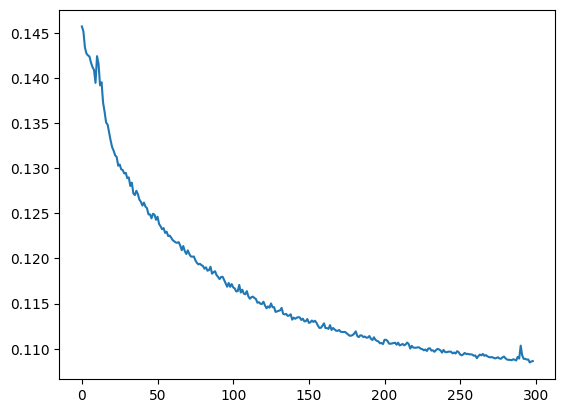

In [12]:
np.save("./models/unet/ep_loss_drums.npy", ep_loss)
plt.plot(ep_loss[4:])

In [13]:
data_folder = '../data/data_spect_real_513/train/mix'
gt_folder = '../data/data_spect_real_513/train/bass'

dataset = CustomDataset(data_folder, gt_folder, transform=None)
batch_size = 16
print(dataset.__len__())
num_workers = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers, multiprocessing_context="fork")

1342


In [ ]:
# Step 2: Choose a loss function
#criteria = SSIMLoss()
# criteria = criteria.to(device)
criteria = nn.L1Loss()
print("Start!")

folder_name = "./models/unet/"
file_paths = glob(folder_name + "*.pt")
number = len(file_paths)

path = folder_name + "model_bass_"
if number < 10:
    path = path + "0" + str(number) + ".pt"
else:
    path = path + str(number) + ".pt"

print("The saving path is: ", path)
print("                      ")

# Step 3: Choose an optimizer and set learning rate
#model = UNet(n_channels=2, n_classes=1, bilinear=1)
model = MusicSep()
model = model.to(device)
#inicijalno 0.0001 posle se mnozi za 0.9 na svakih 10k koraka
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
dataset_size = dataset.__len__()

# Step 4: Training loop
#200K iteracija
num_epochs = 400
ep_loss = []
running_loss = 0.0
min_loss = 200

#-------------------
#trening
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    print(f' Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    running_loss = 0.0

    for batch_idx, (input_data, output_data) in enumerate(data_loader):
        input_data = (input_data.to(dtype = torch.float32)).to(device)
        output_data = (output_data.to(dtype = torch.float32)).to(device)

        optimizer.zero_grad()  # Zero out the gradients
        outputs = (model(input_data)).to(device)
        
        results = torch.multiply(outputs, input_data)
        #results = np.multiply(outputs, input_data)
        results = results.to(device)
        
        #loss = criteria(results, references)
        loss = criteria(results, output_data)
        writer.add_scalar("Loss/train", loss, epoch)


        #statistika
        running_loss += loss.item()
        #running_corrects += torch.sum(preds == labels.data).item()
        
        #train_losses.append(loss.item())
        #train_accuracies.append(accuracy.item())
        
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    
    
    scheduler.step()
    epoch_loss = running_loss / len(data_loader)
    ep_loss.append(epoch_loss)
    time_elapsed = time.time() - start_time
    #epoch_acc = float(running_corrects) / dataset_size

    # print(f'Loss: {epoch_loss:.4f}')
    print(f' Vreme trajanja epohe {(time_elapsed)} \n epoch: {epoch+1}   loss: {epoch_loss}')
    if min_loss > epoch_loss:
        torch.save(model.state_dict(), path)
    saving_loss(ep_loss)

    if epoch % 10 == 0:
        np.save("./models/unet/ep_loss_bass.npy", ep_loss)
    
np.save("./models/unet/ep_loss_bass.npy", ep_loss)

print(ep_loss)
plot_loss(ep_loss)
writer.close()
print("DONE!")
    # Optional: Validation loop to evaluate model performance on a validation dataset

# Optional: Save the trained model if needed
# torch.save(model.state_dict(), "trained_model.pth")

Start!
The saving path is:  ./models/unet/model_bass_35.pt
                      
 Epoch 1/400
----------
 Vreme trajanja epohe 28.70633363723755 
 epoch: 1   loss: 0.15138352919547332
 Epoch 2/400
----------
 Vreme trajanja epohe 28.73675560951233 
 epoch: 2   loss: 0.09501323689307485
 Epoch 3/400
----------
 Vreme trajanja epohe 28.894387245178223 
 epoch: 3   loss: 0.092542489990592
 Epoch 4/400
----------
 Vreme trajanja epohe 28.853282928466797 
 epoch: 4   loss: 0.08650126161852054
 Epoch 5/400
----------
 Vreme trajanja epohe 28.850045204162598 
 epoch: 5   loss: 0.08193658305598157
 Epoch 6/400
----------
 Vreme trajanja epohe 28.92615556716919 
 epoch: 6   loss: 0.08057180060339826
 Epoch 7/400
----------
 Vreme trajanja epohe 29.1792209148407 
 epoch: 7   loss: 0.07982971816368047
 Epoch 8/400
----------
 Vreme trajanja epohe 29.173120260238647 
 epoch: 8   loss: 0.07949955131681193
 Epoch 9/400
----------
 Vreme trajanja epohe 28.722973823547363 
 epoch: 9   loss: 0.0803791

In [3]:
loss = np.load('./models/unet/ep_loss_bass.npy')

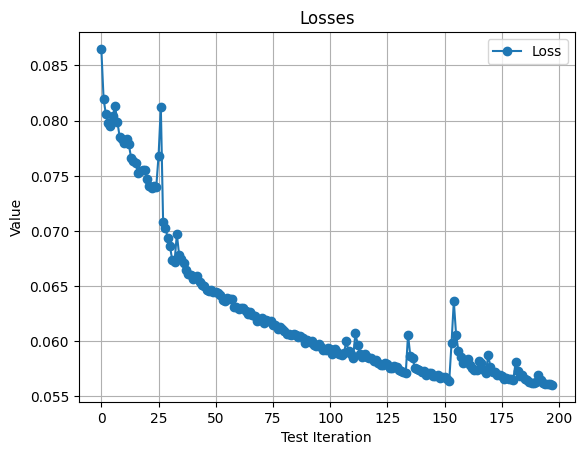

In [6]:
plot_loss(loss[3:])